# Katarina minion damage calculator

The main wave clear combo is:

Q -> Spin -> W -> Spi
Q can hit 3 minions, Spin can hit all (W does no damage).

[Minions Wiki](https://leagueoflegends.fandom.com/wiki/Minion_(League_of_Legends))  

Minions don't have protections.  

[Katarina wiki](https://leagueoflegends.fandom.com/wiki/Katarina/LoL)

In [1]:
import math
import datetime

## Katarina

In [2]:
def q_dmg(ability_lvl:int=1, ap:int=0):
    dmg_at_lvl = [80, 110, 140, 170, 200]
    ap_scale =  1.35
    return dmg_at_lvl[ability_lvl-1] + ap*ap_scale

In [3]:
q_dmg(1, 1)

81.35

### Passive (Sinister Steel) damage

**AP Scaling**  

![ap scaling](./images/katarina_spin_ap_scaling.png)

**Level Scaling**

![image.png](./images/katarina_spin_lvl_scaling.png)

In [4]:
def spin_dmg(lvl:int=1, ap:int=0, bonus_ad:int=0,
             on_hit_dmg:int=0):
    base_dmg_at_lvl = [68, 72, 77, 82, 89, 96, 103, 112, 121, 131, 142, 154, 166, 180, 194, 208, 224, 240]
    if lvl < 1 or lvl > 18:
        raise ValueError(f"Level {lvl} is not within the allowed Sumonner's Rift champion range of 1-18")
    
    lvl_ap_scale = 0.7 +  math.floor((lvl - 1) / 5) * 0.1
    return base_dmg_at_lvl[lvl-1] + ap * lvl_ap_scale + bonus_ad * 0.6 + on_hit_dmg

In [5]:
spin_dmg(1, 15)

78.5

## Minions

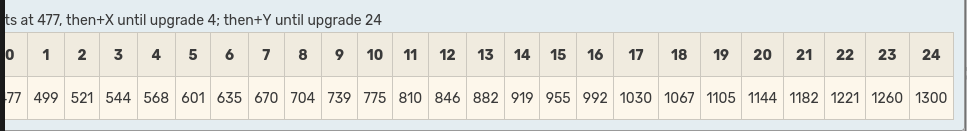

In [6]:
def melee_minion_health(wave_num:int=0):
    # NOTE these minions gain armor at a certain point
    health_upgrades = [477, 499, 521, 544, 568, 601, 635, 670, 704, 739, 775, 810, 846, 882, 919, 955, 992, 1030, 1067, 1105, 1144, 1882, 1221, 1260, 1300]
    upgrade_indx = min(math.floor(wave_num / 3), 24)
    return health_upgrades[upgrade_indx]

In [7]:
print(melee_minion_health(100000),melee_minion_health(2))

1300 477


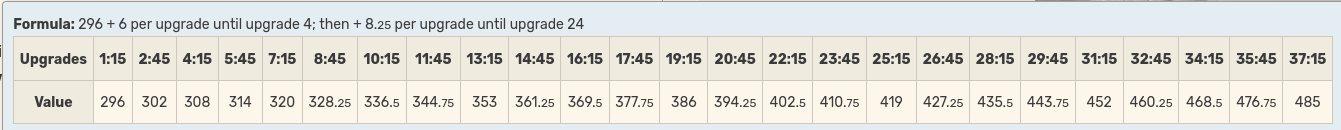

In [8]:
def caster_minion_health(wave_num:int=0):
    base = 296
    upgrade_count = min(math.floor(wave_num / 3), 24)
    if upgrade_count < 5:
        return 296 + upgrade_count * 6
    else:
        return 320 + (upgrade_count - 4) * 8.25

In [9]:
caster_minion_health(1),caster_minion_health(1000)

(296, 485.0)

In [10]:
# skipping for now
def siege_minion_health(wave_num:int=0):
    pass

In [11]:
def wave_num_to_time_secs(wave_num:int=0):
    if wave_num < 1:
        return 0
    return 75 + (wave_num - 1) * 30

In [23]:
secs_to_full_time = lambda s: str(datetime.timedelta(seconds=s))

In [24]:
secs_to_full_time(1)

'0:00:01'

In [13]:
def time_secs_to_wave_num(secs:int):
    time_since_first_wave = secs - 75
    if time_since_first_wave < 0:
        return 0
        
    return math.floor(time_since_first_wave / 30 + 1)

In [21]:
time_secs_to_wave_num(90)

1

In [15]:
DEMATERIALIZER_SCALES = [1.06,1.09,1.12]

In [16]:
def get_demat_scale(used:int):
    if used < 1:
        return 1
        
    return DEMATERIALIZER_SCALES[used - 1]

### Runes

[Adaptive force](https://leagueoflegends.fandom.com/wiki/Adaptive_force)  
Runes at +9  
AD scales 0.6, AP scale 1

In [5]:
def adaptive_force_runes_dmg(a_type:str = "ap", count:int = 0):
    base_dmg = 9
    if count > 2 or count < 0:
        raise ValueError(f"Only 0-2 adaptive runes are available.")
    if a_type == "ap":
        return count * base_dmg
    if a_type == "ad":
        return count * base_dmg * 0.6

In [7]:
adaptive_force_runes_dmg("ap", 1)

9

### Analysis

In [17]:
twospins = lambda *args, **kwargs: 2 * spin_dmg(*args, **kwargs)

In [18]:
twospins(3)

154.0

In [19]:
def analyze(secs, lvl, ap, q_lvl, bonus_ad, on_hit_dmg, caster_demats_used, melee_demats_used):    
    wave_num = time_secs_to_wave_num(secs)
    health_melees = melee_minion_health(wave_num)
    health_casters = caster_minion_health(wave_num)
    two_spins = twospins(lvl, ap, bonus_ad, on_hit_dmg,)
    q = q_dmg(q_lvl, ap)
    dmg_to_melees = round(q + two_spins * get_demat_scale(melee_demats_used))
    dmg_to_casters = round(two_spins * get_demat_scale(caster_demats_used))
    print(f"""On wave {wave_num} at time {secs_to_full_time(secs)}

Health of melees = {health_melees}
Health of ranged = {health_casters}
Damage to melees = {dmg_to_melees}
Damage to ranged = {dmg_to_casters}

Remaining health of melees = {health_melees - dmg_to_melees}
Remaining health of ranged = {health_casters - dmg_to_casters}""")

In [25]:
analyze(
    secs = 6 * 60,
    # katarina
    ap = 30,
    lvl = 3,
    q_lvl = 1,
    bonus_ad = 0,
    on_hit_dmg = 0,
    # demateriliazer state
    caster_demats_used = 0,
    melee_demats_used = 0
)

On wave 10 at time 0:06:00

Health of melees = 544
Health of ranged = 314
Damage to melees = 316
Damage to ranged = 196

Remaining health of melees = 228
Remaining health of ranged = 118


### Gold
[lol gold wiki](https://leagueoflegends.fandom.com/wiki/Gold_(League_of_Legends))

In [26]:
def calc_cs(secs:int, efficiency:float = 0.7):
    wave_num = time_secs_to_wave_num(secs)
    max_cs_per_wave = 6.33
    return wave_num * max_cs_per_wave * efficiency

In [55]:
calc_cs(60*6, 0.8)

50.64

In [28]:
def calc_gold_at_time(secs:int, efficiency:float = 0.7):
    gold_per_cs = 20
    passive_gold = 0
    if secs > 110:
        passive_gold = (secs - 110) * 20.4/10

    return 500 + calc_cs(secs, efficiency) * gold_per_cs + passive_gold

In [58]:
(calc_gold_at_time(112), calc_gold_at_time(60*6, 0.6))

(681.32, 1769.6)

In [53]:
amp_tome = (435, 20)
bwand = (850, 40)
fcodex = (900, 35) # amp_tome + 465
dseal = (350, 15)
potion = (50, 0)
refill_pot = (150, 0)
(bwand[0] + amp_tome[0] + dseal[0] + refill_pot[0],
bwand[0] + fcodex[0] + potion[0]*1,
amp_tome[0] + dseal[0])

(1785, 1800, 785)

In [43]:
secs = 60 * 6 # 6 mins
cs_eff = 0.65
print(f"""
Assume CS {calc_cs(secs, cs_eff)} which gives us {calc_gold_at_time(secs,cs_eff)} gold.""")
analyze(
    secs = 6 * 60,
    # katarina
    ap = bwand[1] + amp_tome[1] + dseal[1],
    lvl = 5,
    q_lvl = 3,
    bonus_ad = 0,
    on_hit_dmg = 0,
    # demateriliazer state
    caster_demats_used = 0,
    melee_demats_used = 2
)


Assume CS 41.144999999999996 which gives us 1832.8999999999999 gold.
On wave 10 at time 0:06:00

Health of melees = 544
Health of ranged = 314
Damage to melees = 550
Damage to ranged = 283

Remaining health of melees = -6
Remaining health of ranged = 31


In [52]:
secs = 60 * 6
cs_eff = 0.65
print(f"""
Assume CS {calc_cs(secs, cs_eff)} which gives us {calc_gold_at_time(secs,cs_eff)} gold.""")
analyze(
    secs = 7 * 60,
    # katarina
    ap = bwand[1] + amp_tome[1] + dseal[1] + 4, # 1 assist on dseal 
    lvl = 6,
    q_lvl = 4,
    bonus_ad = 0,
    on_hit_dmg = 0,
    # demateriliazer state
    caster_demats_used = 0,
    melee_demats_used = 0
)


Assume CS 41.144999999999996 which gives us 1832.8999999999999 gold.
On wave 12 at time 0:07:00

Health of melees = 568
Health of ranged = 320
Damage to melees = 595
Damage to ranged = 318

Remaining health of melees = -27
Remaining health of ranged = 2


In [33]:
secs = 60 * 6.33
cs_eff = 0.6
print(f"""
Assume CS {calc_cs(secs, cs_eff)} which gives us {calc_gold_at_time(secs,cs_eff)} gold.""")
analyze(
    secs = 6 * 60,
    # katarina
    ap = bwand[1] + fcodex[1],
    lvl = 5,
    q_lvl = 3,
    bonus_ad = 0,
    on_hit_dmg = 0,
    # demateriliazer state
    caster_demats_used = 0,
    melee_demats_used = 2
)


Assume CS 41.778 which gives us 1885.952 gold.
On wave 10 at time 0:06:00

Health of melees = 544
Health of ranged = 314
Damage to melees = 550
Damage to ranged = 283

Remaining health of melees = -6
Remaining health of ranged = 31


### Conclusion

Best build for early roaming is dseal, bwand, amp tome.
To consistently one shot the melees by 6 minutes:
- Earn, 1285 gold by 6 minutes (~41 CS)
- Demat 2 of the melees


Less consistent, if we get one early kill then dseal adds +4 AP.  
We can one shot the whole wave by 6 minutes:
- Earn, 1285 gold
- Demat 2 ranged
- Demat 1 melee
